### TensorFlow中神经网络模块
（1）tf.nn ：提供神经网络相关操作的支持，包括卷积操作（conv）、池化操作（pooling）、归一化、loss、分类操作、embedding、RNN、Evaluation。

（2）tf.layers：主要提供的高层的神经网络，主要和卷积相关的，个人感觉是对tf.nn的进一步封装，tf.nn会更底层一些。

（3）tf.contrib：tf.contrib.layers提供够将计算图中的  网络层、正则化、摘要操作、是构建计算图的高级操作，但是tf.contrib包含不稳定和实验代码，有可能以后API会改变。

以上三个模块的封装程度是逐个递进的

__conv2d(input, filter, strides, padding, use_cudnn_on_gpu=True, data_format='NHWC', dilations=[1, 1, 1, 1], name=None)__

（1）第一个参数input：指需要做卷积的输入图像，它要求是一个Tensor，具有[batch, in_height, in_width, in_channels]这样的shape，具体含义是[训练时一个batch的图片数量, 图片高度, 图片宽度, 图像通道数]，注意这是一个4维的Tensor，要求类型为float32和float64其中之一

（2）第二个参数filter：相当于CNN中的卷积核，它要求是一个Tensor，具有[filter_height, filter_width, in_channels, out_channels]这样的shape，具体含义是[卷积核的高度，卷积核的宽度，图像通道数，卷积核个数]，要求类型与参数input相同，有一个地方需要注意，第三维in_channels，就是参数input的第四维

（3）第三个参数strides：卷积时在图像每一维的步长，这是一个一维的向量，长度4

（4）第四个参数padding：string类型的量，只能是"SAME","VALID"其中之一，这个值决定了不同的卷积方式（后面会介绍）

（5）第五个参数：use_cudnn_on_gpu:bool类型，是否使用cudnn加速，默认为true

（6）第六个参数：data_format:可选值有"NHWC", "NCHW"，TensorFlow中channel在最后，即[batch, height, width, channels]，选择NHWC

 结果返回一个Tensor，这个输出，就是我们常说的feature map

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

D:\AI\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### 加载数据

In [2]:
data = np.load('../data/data_with_labels.npz')
data.keys()

['arr_0', 'arr_1']

In [3]:
print(data['arr_0'].shape)
print(data['arr_1'].shape)

(2790, 36, 36)
(2790,)


In [4]:
train = data['arr_0'] / 255.
labels = data['arr_1']

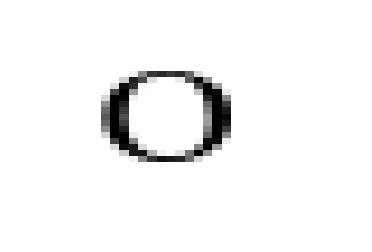

In [5]:
plt.pcolor(train[0],cmap=plt.cm.gray_r)
plt.axis('off')
plt.show()

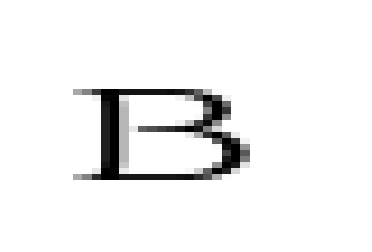

In [6]:
plt.pcolor(train[100],cmap=plt.cm.gray_r)
plt.axis('off')
plt.show()

### 处理数据

- OneHot编码

In [7]:
oh = OneHotEncoder(sparse=False)
labels = oh.fit_transform(labels.reshape(-1, 1))
labels[-1]

array([0., 0., 0., 0., 1.])

- 分割数据,10%作为测试数据,其余做训练数据

In [8]:
X_train, X_test, y_train, y_test = train_test_split(train, labels, test_size=0.1, random_state=666)

### 搭建模型

In [9]:
SHAPE = 36*36
CLASSES = 5
num_filters1 = 16 #卷积核个数
winx1 = 3 #卷积核尺寸
winy1 = 3
num_filters2 = 4
winx2 = 3
winy2 = 3
num_hidden = 32 #全连接层

x = tf.placeholder("float", [None, 36, 36]) #图像是36*36像素
x_im = tf.reshape(x, [-1, 36, 36, 1])
y_ = tf.placeholder("float", [None, CLASSES]) #分为5个类别

# 第一层卷积神经网络
W1 = tf.Variable(tf.truncated_normal([winx1, winy1, 1 , num_filters1], stddev=1./math.sqrt(winx1*winy1)))
b1 = tf.Variable(tf.constant(0.1,shape=[num_filters1]))
xw = tf.nn.conv2d(x_im, W1, strides=[1, 1, 1, 1], padding='SAME')
h1 = tf.nn.relu(xw + b1)
# 2*2池化
p1 = tf.nn.max_pool(h1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

# 第二层卷积神经网络
W2 = tf.Variable(tf.truncated_normal([winx2, winy2, num_filters1, num_filters2],stddev=1./math.sqrt(winx2*winy2)))
b2 = tf.Variable(tf.constant(0.1,shape=[num_filters2]))
p1w2 = tf.nn.conv2d(p1, W2,strides=[1, 1, 1, 1], padding='SAME')
h1 = tf.nn.relu(p1w2 + b2)
# 2*2池化
p2 = tf.nn.max_pool(h1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

# Flatten
p2_size = np.product([s.value for s in p2.get_shape()[1:]])
p2f = tf.reshape(p2, [-1, p2_size ])

# 全连接层
W3 = tf.Variable(tf.truncated_normal([p2_size, num_hidden],stddev=2./math.sqrt(p2_size)))
b3 = tf.Variable(tf.constant(0.2,shape=[num_hidden]))
h3 = tf.nn.relu(tf.matmul(p2f,W3) + b3)

# Dropout
keep_prob = tf.placeholder("float")
h3_drop = tf.nn.dropout(h3, keep_prob)

# 输出层
W4 = tf.Variable(tf.truncated_normal([num_hidden, CLASSES], stddev=1./math.sqrt(num_hidden)))
b4 = tf.Variable(tf.constant(0.1,shape=[CLASSES]))
y = tf.nn.softmax(tf.matmul(h3_drop,W4) + b4)

In [10]:
# 损失函数
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = y + 1e-50, labels = y_))
# 梯度下降法求解最优值
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
#准确率
correct_prediction = tf.equal(tf.argmax(y,1),tf.argmax(y_,1))
accuracy=tf.reduce_mean(tf.cast(correct_prediction, "float"))

### 训练模型

In [11]:
init = tf.global_variables_initializer()
epochs = 10000
train_acc = []
test_acc = []
j = 0

with tf.Session() as sess:
    sess.run(init)
    
    for i in range(epochs):
        sess.run(train_step, feed_dict={x : X_train, y_ : y_train, keep_prob: 0.5})
        if i % 20 == 0:
            trainacc = sess.run(accuracy, feed_dict={x : X_train, y_ : y_train, keep_prob: 1.0})
            train_acc.append(trainacc)
            testacc = sess.run(accuracy, feed_dict={x : X_test, y_ : y_test, keep_prob: 1.0})
            test_acc.append(testacc)
            print("step: %4d, train_acc %.6f, test_acc %.6f" % (i, trainacc, testacc))
    
    #Save the weights
    saver = tf.train.Saver()
    saver.save(sess, "models/conv2a.ckpt")

step:    0, train_acc 0.188371, test_acc 0.179211
step:   20, train_acc 0.182796, test_acc 0.179211
step:   40, train_acc 0.184389, test_acc 0.186380
step:   60, train_acc 0.191557, test_acc 0.179211
step:   80, train_acc 0.205894, test_acc 0.182796
step:  100, train_acc 0.221027, test_acc 0.186380
step:  120, train_acc 0.240940, test_acc 0.207885
step:  140, train_acc 0.265631, test_acc 0.222222
step:  160, train_acc 0.282756, test_acc 0.232975
step:  180, train_acc 0.291916, test_acc 0.261649
step:  200, train_acc 0.299881, test_acc 0.272401
step:  220, train_acc 0.300677, test_acc 0.268817
step:  240, train_acc 0.313819, test_acc 0.283154
step:  260, train_acc 0.338909, test_acc 0.326165
step:  280, train_acc 0.359219, test_acc 0.326165
step:  300, train_acc 0.366786, test_acc 0.369176
step:  320, train_acc 0.366786, test_acc 0.379928
step:  340, train_acc 0.374751, test_acc 0.390681
step:  360, train_acc 0.381521, test_acc 0.390681
step:  380, train_acc 0.383114, test_acc 0.401434


step: 3280, train_acc 0.804062, test_acc 0.792115
step: 3300, train_acc 0.806053, test_acc 0.799283
step: 3320, train_acc 0.805655, test_acc 0.795699
step: 3340, train_acc 0.805655, test_acc 0.792115
step: 3360, train_acc 0.808045, test_acc 0.795699
step: 3380, train_acc 0.806452, test_acc 0.799283
step: 3400, train_acc 0.806053, test_acc 0.792115
step: 3420, train_acc 0.806452, test_acc 0.799283
step: 3440, train_acc 0.807248, test_acc 0.806452
step: 3460, train_acc 0.808841, test_acc 0.799283
step: 3480, train_acc 0.810434, test_acc 0.802867
step: 3500, train_acc 0.810434, test_acc 0.802867
step: 3520, train_acc 0.811231, test_acc 0.799283
step: 3540, train_acc 0.812425, test_acc 0.810036
step: 3560, train_acc 0.812027, test_acc 0.806452
step: 3580, train_acc 0.812425, test_acc 0.810036
step: 3600, train_acc 0.812425, test_acc 0.802867
step: 3620, train_acc 0.813222, test_acc 0.806452
step: 3640, train_acc 0.814018, test_acc 0.799283
step: 3660, train_acc 0.812824, test_acc 0.810036


step: 6560, train_acc 0.874154, test_acc 0.874552
step: 6580, train_acc 0.874950, test_acc 0.874552
step: 6600, train_acc 0.874154, test_acc 0.874552
step: 6620, train_acc 0.873755, test_acc 0.874552
step: 6640, train_acc 0.875348, test_acc 0.874552
step: 6660, train_acc 0.875747, test_acc 0.874552
step: 6680, train_acc 0.877340, test_acc 0.874552
step: 6700, train_acc 0.876145, test_acc 0.874552
step: 6720, train_acc 0.878534, test_acc 0.874552
step: 6740, train_acc 0.877738, test_acc 0.874552
step: 6760, train_acc 0.877738, test_acc 0.874552
step: 6780, train_acc 0.878534, test_acc 0.874552
step: 6800, train_acc 0.877738, test_acc 0.874552
step: 6820, train_acc 0.880127, test_acc 0.874552
step: 6840, train_acc 0.880526, test_acc 0.874552
step: 6860, train_acc 0.880526, test_acc 0.874552
step: 6880, train_acc 0.880526, test_acc 0.874552
step: 6900, train_acc 0.881322, test_acc 0.874552
step: 6920, train_acc 0.880526, test_acc 0.874552
step: 6940, train_acc 0.881720, test_acc 0.874552


step: 9840, train_acc 0.914377, test_acc 0.899642
step: 9860, train_acc 0.915173, test_acc 0.896057
step: 9880, train_acc 0.914775, test_acc 0.899642
step: 9900, train_acc 0.915970, test_acc 0.896057
step: 9920, train_acc 0.915572, test_acc 0.899642
step: 9940, train_acc 0.915572, test_acc 0.903226
step: 9960, train_acc 0.915572, test_acc 0.903226
step: 9980, train_acc 0.914775, test_acc 0.896057


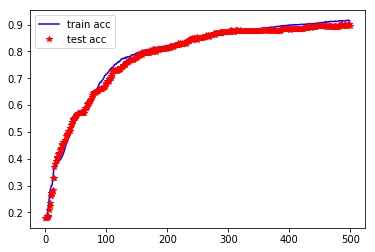

In [12]:
plt.plot(np.arange(len(train_acc)), train_acc, 'b-', label='train acc')
plt.plot(np.arange(len(test_acc)), test_acc, 'r*', label='test acc')
plt.legend(loc='best')
plt.show()